# Sentiment Analysis of Tweets Data
Finetuning distilbert for emotions predictions of tweets data from hugging face.

## Install Required Libraries

In [1]:
# install datasets library from huggingface

!pip install -q datasets
!pip install -q transformers
!pip install -q accelerate -U
!pip install -q transformers[torch]
!pip install -q huggingface_hub -U
!pip install -q umap-learn
!pip install -q streamlit
!npm install -g localtunnel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

## Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import plotly.express as px

from datasets import list_datasets
from datasets import load_dataset

import torch
from torch.nn.functional import cross_entropy

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, pipeline

from huggingface_hub import login

from google.colab import userdata

In [3]:
all_datasets = list_datasets()

<ipython-input-3-f6f3a82aff2d>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
print(f'There are {len(all_datasets)} data in datasets')

There are 122469 data in datasets


In [5]:
print(f'Last 5 datasets are {all_datasets[-5:]}')

Last 5 datasets are ['St4n/common_voice_13_0_hi_pseudo_labelled', 'JnKamasMTS/second_test', 'HLasse/finnish-emotions', 'open-llm-leaderboard/details_mlabonne__UltraMerge-7B', 'garboab/fonda_pretrain_en_tokenized_v1']


## Load Data

In [6]:
# get 'emotions' data from all_datasets

emotions = load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
type(emotions)

datasets.dataset_dict.DatasetDict

In [8]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [9]:
# let's get train, validation, test

emo_train = emotions["train"]
emo_test = emotions["test"]
emo_val = emotions["validation"]

In [10]:
print(type(emo_train))

<class 'datasets.arrow_dataset.Dataset'>


In [11]:
emo_train[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [12]:
# print out the column or feature

emo_train.column_names

['text', 'label']

In [13]:
# dir(emo_train)

In [14]:
# get features

emo_train.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

So far we got label with description:
* 0 = sadness
* 1 = joy
* 2 = love
* 3 = anger
* 4 = fear
* 5 = suprise

In [15]:
# get only the text data

emo_train["text"][:10]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i feel as confused about life as a teenager or as jaded as a year old man',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too']

In [16]:
emo_train["label"][:10]

[0, 0, 3, 2, 3, 0, 5, 4, 1, 2]

In [17]:
# convert emotions from DatasetDict to Pandas dataframe

emotions.set_format(type="pandas")

In [18]:
df_train = emotions["train"][:]
df_val = emotions["validation"][:]
df_test = emotions["test"][:]
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [19]:
df_train.shape

(16000, 2)

In [20]:
# val_df.head()

In [21]:
# test_df.head()

In [22]:
def get_label_name(row):
  return emotions["train"].features["label"].int2str(row)

In [23]:
# now get the description of the label

df_train["label_name"] = df_train["label"].apply(lambda x: get_label_name(x))
df_val["label_name"] = df_val["label"].apply(lambda x: get_label_name(x))
df_test["label_name"] = df_test["label"].apply(lambda x: get_label_name(x))

In [24]:
df_train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [25]:
df_val.head()

,text,label,label_name
0,im feeling quite sad and sorry for myself but ...,0,sadness
1,i feel like i am still looking at a blank canv...,0,sadness
2,i feel like a faithful servant,2,love
3,i am just feeling cranky and blue,3,anger
4,i can have for a treat or if i am feeling festive,1,joy


In [26]:
df_test.head()

,text,label,label_name
0,im feeling rather rotten so im not very ambiti...,0,sadness
1,im updating my blog because i feel shitty,0,sadness
2,i never make her separate from me because i do...,0,sadness
3,i left with my bouquet of red and yellow tulip...,1,joy
4,i was feeling a little vain when i did this one,0,sadness


In [27]:
# lets backup data by load it to csv

PATH = 'data_emotion'
if not os.path.exists(PATH):
  os.makedirs(PATH)

df = [df_train, df_val, df_test]
names = ['train', 'validation', 'test']
for i, df in enumerate(df):
  df.to_csv(f'{PATH}/{names[i]}.csv', index = False)

## EDA The Text Tweets

In [28]:
# check class distribution

def label_dist(df):
  fig = px.bar(df["label_name"].value_counts(ascending = True).reset_index(),
              x = "label_name",
              y = "index",
              orientation = "h")
  fig.update_layout(title_text = "Emotions Distributions")
  fig.show()

In [29]:
# class distribution for train data

label_dist(df_train)

In [30]:
# class distribution for train data

label_dist(df_val)

In [31]:
# class distribution for train data

label_dist(df_test)

it seems like the class distribution is imbalance. we can apply resampling for this imbalance data later. refer to [imbalanced-learn](https://imbalanced-learn.org/stable/)

In [32]:
# check the tweet length distributions for each class

def words_distr(df):
  df["words_per_tweet"] = df["text"].str.split().apply(len)
  fig = px.box(df, x="label_name", y="words_per_tweet", color = "label_name")
  fig.update_layout(title_text = "Number of Tweets Distribution")
  fig.show()

In [33]:
# Number of tweets distribution : TRAIN DATA

words_distr(df_train)

In [34]:
# Number of tweets distribution : VALIDATION DATA

words_distr(df_val)

In [35]:
# Number of tweets distribution : TEST DATA

words_distr(df_test)

## Text Preprocessing

### 1. Tokenization

#### A. Character Tokenization

In [36]:
text = "NLP is such a hype now. It's everywhere. I kinda bored with this topic now"

In [37]:
# example:
# Character Tokenization
tokenized_text = list(text)
print(tokenized_text)

['N', 'L', 'P', ' ', 'i', 's', ' ', 's', 'u', 'c', 'h', ' ', 'a', ' ', 'h', 'y', 'p', 'e', ' ', 'n', 'o', 'w', '.', ' ', 'I', 't', "'", 's', ' ', 'e', 'v', 'e', 'r', 'y', 'w', 'h', 'e', 'r', 'e', '.', ' ', 'I', ' ', 'k', 'i', 'n', 'd', 'a', ' ', 'b', 'o', 'r', 'e', 'd', ' ', 'w', 'i', 't', 'h', ' ', 't', 'h', 'i', 's', ' ', 't', 'o', 'p', 'i', 'c', ' ', 'n', 'o', 'w']


In [38]:
# lets do numericalization
# inputs = {' ' : 1, 'N' : 2, dst}
# encoding each unique token from our token text

token_idx = {chr: idx for idx, chr in enumerate(sorted(set(tokenized_text)))}
print(token_idx)

{' ': 0, "'": 1, '.': 2, 'I': 3, 'L': 4, 'N': 5, 'P': 6, 'a': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'h': 12, 'i': 13, 'k': 14, 'n': 15, 'o': 16, 'p': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'y': 24}


In [39]:
# then we replace the token with the number in our input_ds dict

input_ids = [token_idx[token] for token in tokenized_text]

In [40]:
print(input_ids)

[5, 4, 6, 0, 13, 19, 0, 19, 21, 9, 12, 0, 7, 0, 12, 24, 17, 11, 0, 15, 16, 23, 2, 0, 3, 20, 1, 19, 0, 11, 22, 11, 18, 24, 23, 12, 11, 18, 11, 2, 0, 3, 0, 14, 13, 15, 10, 7, 0, 8, 16, 18, 11, 10, 0, 23, 13, 20, 12, 0, 20, 12, 13, 19, 0, 20, 16, 17, 13, 9, 0, 15, 16, 23]


#### B. Word Tokenization

In [41]:
token_word = text.split()
print(token_word)

['NLP', 'is', 'such', 'a', 'hype', 'now.', "It's", 'everywhere.', 'I', 'kinda', 'bored', 'with', 'this', 'topic', 'now']


A common approach is to limit the vocabulary and discard rare words by considering, say, the 100,000 most common words in the corpus.

#### C. Subword Tokenization

balancing our trade-off between characater tokenization and word tokenization.

In [42]:
# call the autotokenization from transformers

In [43]:
# define model checkpoint

model_ckpt = "distilbert-base-uncased"

In [44]:
# now define our auto tokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [45]:
# encode the text again with tokenizer from this distilbert

tokens_encode = tokenizer(text)
tokens_encode

{'input_ids': [101, 17953, 2361, 2003, 2107, 1037, 1044, 18863, 2085, 1012, 2009, 1005, 1055, 7249, 1012, 1045, 17704, 11471, 2007, 2023, 8476, 2085, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [46]:
# lets convert the numerical representations back to text or tokens

tokens = tokenizer.convert_ids_to_tokens(tokens_encode.input_ids)

In [47]:
print(tokens)

['[CLS]', 'nl', '##p', 'is', 'such', 'a', 'h', '##ype', 'now', '.', 'it', "'", 's', 'everywhere', '.', 'i', 'kinda', 'bored', 'with', 'this', 'topic', 'now', '[SEP]']


In [48]:
# tokens can also be merge back

print(tokenizer.convert_tokens_to_string(tokens))

[CLS] nlp is such a hype now. it ' s everywhere. i kinda bored with this topic now [SEP]


In [49]:
# let's inspect the vocab size from tokenizer

tokenizer.vocab_size

30522

In [50]:
# lets print out the maximum text length / context size

tokenizer.model_max_length

512

In [51]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### Tokenize the Whole Data

In [52]:
# let's reset the type of emotions

emotions.reset_format()

In [53]:
# lets try tokenize some small chunks of our data

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [54]:
print(emotions["train"][:1])
print(tokenize(emotions["train"][:1]))

{'text': ['i didnt feel humiliated'], 'label': [0]}
{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1]]}


In [55]:
# apply the tokenize function to the corpus

emotions_encoded = emotions.map(tokenize, batched = True, batch_size = None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [56]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

now our data is already in encoded state.

## Training Process

In [57]:
# check if gpu is available, if yes, then use gpu, else use cpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
# define our model

model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

AutoModel will convert the token encoding in emotions_encoded to token embedded.

#### Extract Last Hidden States

In [59]:
# lets start with text example

inputs = tokenizer(text, return_tensors = "pt")

In [60]:
inputs

{'input_ids': tensor([[  101, 17953,  2361,  2003,  2107,  1037,  1044, 18863,  2085,  1012,
          2009,  1005,  1055,  7249,  1012,  1045, 17704, 11471,  2007,  2023,
          8476,  2085,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [61]:
# lets print out the shape of tensors

inputs["input_ids"].size()

torch.Size([1, 23])

torch.Size([1,23]) represent the size of (batch_size, number_tokens).\
Now we will have the encodings as a tensor, but we need to place it in the same device as model.

In [62]:
# lets get the hidden state aka tensors

inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad(): # disable calculation of gradient, reduce memory footprint
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[ 0.2732, -0.0103, -0.0158,  ..., -0.0667,  0.3906,  0.3563],
         [ 0.3916, -0.5973,  0.2589,  ..., -0.0965,  0.5955,  0.1668],
         [ 0.2663, -0.2995,  0.2723,  ..., -0.0666, -0.0524,  0.1265],
         ...,
         [ 0.4202,  0.1448, -0.1921,  ...,  0.2691,  0.0510, -0.1038],
         [-0.0734, -0.3562, -0.2823,  ...,  0.3069,  0.2740, -0.4645],
         [ 0.5940,  0.1363,  0.3398,  ...,  0.2960, -0.0640, -0.1421]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [63]:
# check the size

outputs.last_hidden_state.size()

torch.Size([1, 23, 768])

the size of torch is [batch, num_token, hidden_dim]

In [64]:
def extract_hidden_states(batch):
    # put the model in gpu
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    # get last hidden states
    with torch.no_grad():
      last_hidden_states = model(**inputs).last_hidden_state

    # lets return vector
    return {"hidden_state" : last_hidden_states[:,0].cpu().numpy()}

place the hidden state back to cpu in numpy array format so it can be applied to map() function.\
since our `extract_hidden_states` expect the inputs to be tensor, we need convert the emotions_encoded to tensor.

In [65]:
# we can utilize set_format in hugging face

emotions_encoded.set_format("torch",
                            columns = ["input_ids", "attention_mask", "label"])

now our emotions data is already in tensor format, we can now map the `extract_hidden_states` to this.

In [66]:
# lets assign to new object

emotions_hidden = emotions_encoded.map(extract_hidden_states, batched = True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [67]:
emotions_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [68]:
# lets checkout the first row

# emotions_hidden["train"][0]

Now our dataset is ready to be trained on Classifiers. But, we need the format to be in array, so import numpy.
We will have classification model with :
* features (predictor) = hidden state
* label (y) = label

So before we get the dataframe, we need to get the array of hidden states


In [69]:
# let's get array of X and y

X_train = np.array(emotions_hidden["train"]["hidden_state"]) # model
X_val = np.array(emotions_hidden["validation"]["hidden_state"]) # model
X_test = np.array(emotions_hidden["test"]["hidden_state"]) # check performance for unseen data


y_train = np.array(emotions_hidden["train"]["label"])
y_val = np.array(emotions_hidden["validation"]["label"])
y_test = np.array(emotions_hidden["test"]["label"])

In [70]:
X_train.shape

(16000, 768)

### Train with ML Classifier

In [71]:
# lets define logistic regression

clf_lr = LogisticRegression(max_iter = 3000)
clf_lr.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [72]:
clf_lr.score(X_train, y_train)

0.694375

In [73]:
clf_lr.score(X_val, y_val)

0.6335

In [74]:
clf_lr.score(X_test, y_test)

0.627

In [75]:
# lets define random forest

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

RandomForestClassifier()

In [76]:
clf_rf.score(X_val, y_val)

0.5155

#### Plot Confusion Matrix

In [77]:
def plot_confusion_matrix(y_true, y_pred, label):
  cm = confusion_matrix(y_true, y_pred, normalize = "true") # show proportion instead count
  fig, ax = plt.subplots(figsize = (8,8))
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = label)
  disp.plot(cmap = "Blues", values_format = ".2f", ax = ax , colorbar = False)
  plt.title("Confusion Matrix (Normalized)")
  plt.show()

In [78]:
y_preds = clf_lr.predict(X_val)

In [79]:
# get labels

labels = emotions["train"].features["label"].names
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

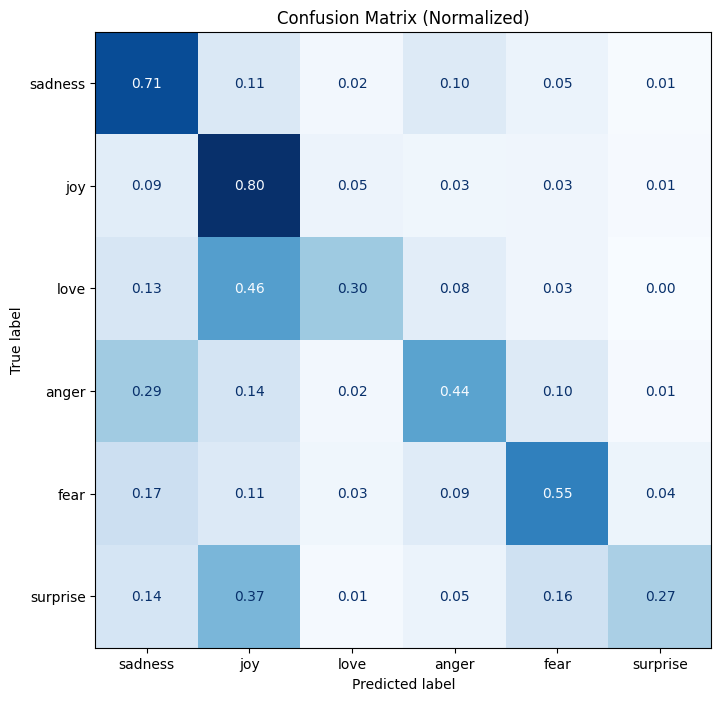

In [80]:
plot_confusion_matrix(y_val, y_preds, labels)

## Fine Tuning Transformers

In [81]:
# define number labels

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels = num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Defining Performance Metrics

In [82]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [86]:
# notebook login

hf_token = userdata.get('HUGGINGFACE_TOKEN')
login(token=hf_token, add_to_git_credential=True)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [89]:
# define training argument

class Config:
    def __init__(self, data, model_ckpt):
      self.batch_size = 64
      self.num_train_epochs = 2
      self.learning_rate = 2e-5
      self.weight_decay = 0.01
      self.evaluation_strategy = "epoch"
      self.logging_steps = len(data["train"]) // self.batch_size
      self.model_name = f"{model_ckpt}-finetuned-emotions"
      self.disable_tqdm = False
      self.push_to_hub = True
      self.log_level = "error"
      self.training_args = {
          "output_dir" : self.model_name,
          "num_train_epochs" : self.num_train_epochs,
          "learning_rate": self.learning_rate,
          "per_device_train_batch_size": self.batch_size,
          "per_device_eval_batch_size": self.batch_size,
          "weight_decay": self.weight_decay,
          "evaluation_strategy": self.evaluation_strategy,
          "disable_tqdm": self.disable_tqdm,
          "logging_steps": self.logging_steps,
          "push_to_hub": self.push_to_hub,
          "log_level": self.log_level
        }

In [90]:
config = Config(emotions_encoded, model_ckpt)
training_args = TrainingArguments(**config.training_args)

In [102]:
# instantiate and fine-tune our model
# apply to emotions_encoded instead

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning:

Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.841900,0.333544,0.900000,0.898603
2,0.260000,0.221134,0.927500,0.927365


TrainOutput(global_step=500, training_loss=0.5509592895507812, metrics={'train_runtime': 237.7391, 'train_samples_per_second': 134.601, 'train_steps_per_second': 2.103, 'total_flos': 720342861696000.0, 'train_loss': 0.5509592895507812, 'epoch': 2.0})

In [103]:
# get predictions

preds_val_set = trainer.predict(emotions_encoded["validation"])
preds_test_set = trainer.predict(emotions_encoded["test"])

In [104]:
# get metrics score

preds_val_set.metrics

{'test_loss': 0.2211337834596634,
 'test_accuracy': 0.9275,
 'test_f1': 0.927364605243016,
 'test_runtime': 4.0668,
 'test_samples_per_second': 491.783,
 'test_steps_per_second': 7.869}

In [105]:
preds_test_set.metrics

{'test_loss': 0.22560586035251617,
 'test_accuracy': 0.92,
 'test_f1': 0.9187741031224365,
 'test_runtime': 3.6067,
 'test_samples_per_second': 554.531,
 'test_steps_per_second': 8.872}

decode the predictions greedily using np.argmax(). This yields the predicted labels and has the same format as the labels returned by the Scikit-learn models in the feature-based approach.

In [106]:
y_preds_val = np.argmax(preds_val_set.predictions, axis=1)
y_preds_test = np.argmax(preds_test_set.predictions, axis=1)

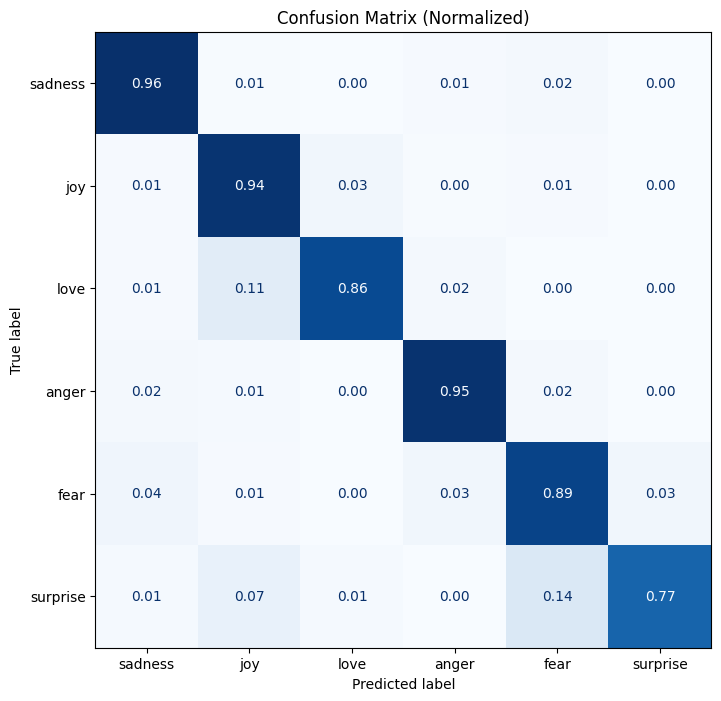

In [107]:
plot_confusion_matrix(y_val, y_preds_val, labels)

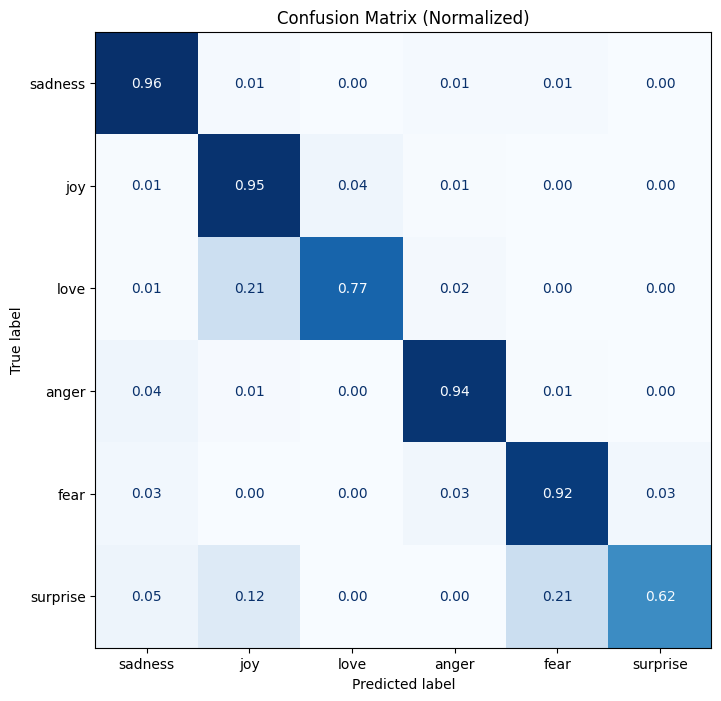

In [108]:
plot_confusion_matrix(y_test, y_preds_test, labels)

#### Error Analysis
Investigate our model’s predictions a little bit further. A simple yet powerful technique is to sort the validation samples by the model loss. When we pass the label during the forward pass, the loss is automatically calculated and returned.

In [109]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [110]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"]) # Convert  dataset back to PyTorch tensors
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=100)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [111]:
# now create pandas dataframe that consists of prediction and loss

emotions_encoded.set_format("pandas")

cols = ["text", "label", "predicted_label", "loss"]

In [113]:
# validation set
df_val = emotions_encoded["validation"][:][cols]
df_val["label"] = df_val["label"].apply(get_label_name)
df_val["predicted_label"] = (df_val["predicted_label"].apply(get_label_name))

In [116]:
df_val.sort_values('loss', ascending = False).head()

,text,label,predicted_label,loss
1801,i feel that he was being overshadowed by the s...,love,sadness,5.913060
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.575479
1963,i called myself pro life and voted for perry w...,joy,sadness,5.478859
1950,i as representative of everything thats wrong ...,surprise,sadness,5.428203
882,i feel badly about reneging on my commitment t...,love,sadness,5.208663


#### Save and Share the Model to HuggingFace Hub

In [117]:
trainer.push_to_hub(commit_message="Training completed!")

events.out.tfevents.1711099677.16d7d252c4f4.329.0:   0%|          | 0.00/6.35k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/cindyangelira/distilbert-base-uncased-finetuned-emotions/commit/51d13766ee03e470c41de71c1f090edb048ec71b', commit_message='Training completed!', commit_description='', oid='51d13766ee03e470c41de71c1f090edb048ec71b', pr_url=None, pr_revision=None, pr_num=None)

## Fine Tuned to Make Prediction for New Tweet

In [118]:
models = "cindyangelira/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=models)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [119]:
custom_tweet = "I saw a movie today and it was really bad."
preds = classifier(custom_tweet, top_k = None)

In [124]:
preds_df = pd.DataFrame(preds)
label_to_emotion = {
        'LABEL_0': 'sadness',
        'LABEL_1': 'joy',
        'LABEL_2': 'love',
        'LABEL_3': 'anger',
        'LABEL_4': 'fear',
        'LABEL_5': 'surprise'
    }
# Apply the mapping to the 'label' column
preds_df['label'] = preds_df['label'].map(label_to_emotion)

In [125]:
prediction = preds_df.sort_values("label", ascending = False)["label"][0]
prediction

'sadness'

In [126]:
fig = px.bar(preds_df,
             x="label",
             y="score",
             title=f'"{custom_tweet}"',
             labels={'score':'Class probability (%)'}, height=400)
fig.show()

## Deploy it via Streamlit

In [129]:
%%writefile app.py
import os
import pandas as pd
import streamlit as st
import plotly.express as px
from transformers import pipeline
from google.colab import userdata
from huggingface_hub import login

# Load config
MODEL_ID = os.getenv("MODEL_ID", "cindyangelira/distilbert-base-uncased-finetuned-emotion")
APP_TITLE = os.getenv("APP_TITLE", "Emotions Predictions")
INPUT_PROMPT = os.getenv("INPUT_PROMPT", "Enter your text here")
PLOT_TITLE = os.getenv("PLOT_TITLE", 'Class probability (%)')

# Define the mapping
LABEL_TO_EMOTION = {
    'LABEL_0': 'sadness',
    'LABEL_1': 'joy',
    'LABEL_2': 'love',
    'LABEL_3': 'anger',
    'LABEL_4': 'fear',
    'LABEL_5': 'surprise'
}

st.title(APP_TITLE)

# get model from hub
classifier = pipeline("text-classification", model=MODEL_ID)

# create widget for input text
custom_tweet = st.text_input(INPUT_PROMPT)

if custom_tweet:
    preds = classifier(custom_tweet, top_k = None)
    preds_df = pd.DataFrame(preds)
    st.write(f'The prediction is {preds}')
    preds_df['label'] = preds_df['label'].map(LABEL_TO_EMOTION)
    st.write(f'The prediction is {preds_df.sort_values("label", ascending = False)["label"][0]}')

    # Plot
    fig = px.bar(preds_df, x="label", y="score", title=f'"{custom_tweet}"', labels={'score':PLOT_TITLE}, height=400)
    st.plotly_chart(fig)

Overwriting app.py


In [ ]:
!streamlit run app.py --server.address=localhost &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.28.5.176
npx: installed 22 in 2.772s
your url is: https://warm-lines-deny.loca.lt


Open the link and put the first line as password.